# scRNA-seq For Kidney Cells Pipeline

This notebook goes step by step to process Mice Kidney scRNA-seq. It is based on the Kideny Framework provided by Dr. John Nelson. The goal of this notebook is to mimic Dr. Nelson's pipeline using python only libraries. This will be integrated into scAgent's pipeline 

In [1]:
# imports 
import pandas as pd
import scanpy as sc
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scvi
import os
from pathlib import Path
import seaborn as sns
import datetime
import openpyxl
import random
import json
from datetime import datetime as dt

# Set seeds for reproducibility
np.random.seed(0)
random.seed(0)

# # optional: nicer plots
# sc.settings.verbosity = 2
# sc.logging.print_header()

/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
print("Testing scAR availability...")
try:
    import scvi
    from scvi.external import SCAR
    print(f"✓ scvi-tools available (version {scvi.__version__})")
    scar_available = True
except ImportError as e:
    print(f"✗ scvi-tools not available: {e}")
    scar_available = False


Testing scAR availability...
✓ scvi-tools available (version 1.4.0)


In [3]:

# Data pathsData_files/raw_data
DATA_DIR = Path('/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/Data_files/raw_data')
RAW_H5 = DATA_DIR / '7_raw_feature_bc_matrix.h5'
FILTERED_H5 = DATA_DIR / '7_filtered_feature_bc_matrix.h5'
META_CSV = DATA_DIR / 'metadata.xlsx - Sheet1.csv'


print(f"✓ Setup complete")
print(f"  Raw H5: {RAW_H5.exists()}")
print(f"  Filtered H5: {FILTERED_H5.exists()}")
print(f"  Metadata CSV: {META_CSV.exists()}")

✓ Setup complete
  Raw H5: True
  Filtered H5: True
  Metadata CSV: True


In [4]:
# Load raw and filtered data
print("Loading data...")
raw = sc.read_10x_h5(str(RAW_H5))
filtered = sc.read_10x_h5(str(FILTERED_H5))
meta = pd.read_csv(str(META_CSV), index_col=0)

# Make var_names unique
raw.var_names_make_unique()
filtered.var_names_make_unique()

# Add metadata to filtered
sample_id = meta.index[0]
for col in meta.columns:
    filtered.obs[col] = meta.loc[sample_id, col]

# Save raw counts
filtered.layers['counts_raw'] = filtered.X.copy()
filtered.obs['sample_ID'] = meta.index.values[0]

print(f"✓ Data loaded")
print(f"  Raw: {raw.shape}")
print(f"  Filtered: {filtered.shape}")
print(f"  Sample ID: {sample_id}")

Loading data...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


✓ Data loaded
  Raw: (1617288, 32285)
  Filtered: (8877, 32285)
  Sample ID: 7Dataset


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
filtered

AnnData object with n_obs × n_vars = 8877 × 32285
    obs: 'animal_species', 'sex', 'age', 'tissue_type', 'treatment', 'processing_date', 'sample_type', 'sample_ID'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts_raw'

In [6]:
raw

AnnData object with n_obs × n_vars = 1617288 × 32285
    var: 'gene_ids', 'feature_types', 'genome'

### QC Metrics

In [7]:
def _ensure_qc_columns(adata):
    """
    Make sure the standard QC fields exist with consistent names:
    n_genes, total_counts, pct_mito (percent mitochondrial).
    """
    # Mito mask + Scanpy QC (adds e.g. pct_counts_mt)
    if 'mt' not in adata.var:
        adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

    # Unify naming across Scanpy versions
    if 'n_genes' not in adata.obs and 'n_genes_by_counts' in adata.obs:
        adata.obs['n_genes'] = adata.obs['n_genes_by_counts']

    if 'total_counts' not in adata.obs:
        X = adata.X
        adata.obs['total_counts'] = np.ravel(X.sum(axis=1)) if sp.issparse(X) else X.sum(axis=1)

    if 'pct_mito' not in adata.obs:
        adata.obs['pct_mito'] = adata.obs.get('pct_counts_mt', 0)

def violin_qc(
    adata,
    sample_name,
    stage_label,
    groupby=None,
    output_dir='./outputs'
):
    """
    Save a 3‑panel QC violin (n_genes, total_counts, pct_mito).
    Optionally group by e.g. 'DF.class', 'subclass', 'class', or 'type'.
    """
    _ensure_qc_columns(adata)

    figdir = Path(output_dir) / 'figures'
    figdir.mkdir(parents=True, exist_ok=True)
    sc.settings.figdir = str(figdir)
    sc.settings.file_format_figs = 'pdf'

    keys = ['n_genes', 'total_counts', 'pct_mito']
    sc.pl.violin(
        adata,
        keys=keys,
        groupby=groupby,        # None | 'DF.class' | 'subclass' | 'class' | 'type'
        rotation=45,
        stripplot=False,        # closer to Seurat’s cleaner violins
        jitter=0.4,
        show=True,
        save=f'_{sample_name}_{stage_label}_qc'  # -> figures/violin_{suffix}.pdf
    )

In [8]:
def compute_qc_metrics(adata, name=''):
    """Compute QC metrics for AnnData object."""
    X = adata.X
    
    if sp.issparse(X):
        total_counts = np.ravel(X.sum(axis=1))
        n_genes = np.ravel((X > 0).sum(axis=1))
    else:
        total_counts = X.sum(axis=1)
        n_genes = (X > 0).sum(axis=1)
    
    adata.obs['total_counts'] = total_counts
    adata.obs['n_genes'] = n_genes
    
    # Mitochondrial genes
    mt_mask = adata.var_names.str.upper().str.startswith('MT-')
    adata.var['mt'] = mt_mask
    
    if mt_mask.sum() > 0:
        if sp.issparse(X):
            mito_counts = np.ravel(X[:, mt_mask].sum(axis=1))
        else:
            mito_counts = X[:, mt_mask].sum(axis=1)
        adata.obs['pct_mito'] = mito_counts / adata.obs['total_counts'] * 100
    else:
        adata.obs['pct_mito'] = 0
    
    metrics = {
        'name': name,
        'mean_total_counts': float(total_counts.mean()),
        'median_total_counts': float(np.median(total_counts)),
        'std_total_counts': float(total_counts.std()),
        'mean_n_genes': float(n_genes.mean()),
        'median_n_genes': float(np.median(n_genes)),
        'std_n_genes': float(n_genes.std()),
        'mean_pct_mito': float(adata.obs['pct_mito'].mean()),
        'n_cells': adata.n_obs,
        'n_genes': adata.n_vars
    }
    return metrics, adata

# Compute baseline metrics
# baseline_metrics = compute_qc_metrics(filtered.copy(), 'baseline')
# print("✓ QC metrics computed")
# print(f"  Mean counts: {baseline_metrics['mean_total_counts']:.2f}")
# print(f"  Mean genes: {baseline_metrics['mean_n_genes']:.2f}")
# print(f"  Mean % mito: {baseline_metrics['mean_pct_mito']:.2f}")


In [9]:
def checkpoint_umap(
    adata,
    stage_label,
    sample_name,
    output_dir="./outputs",
    layer="counts_denoised",      # start from denoised counts by default
    resolution=2.0,
    show=True,
):
    """
    Compute a quick UMAP on a COPY (tmp) so the main adata stays in counts-space.
    Saves to: outputs/figures/umap_{sample}_{stage_label}.pdf
    """
    import scanpy as sc
    from pathlib import Path

    tmp = adata.copy()
    if (layer is not None) and (layer in tmp.layers):
        tmp.X = tmp.layers[layer].copy()

    sc.pp.normalize_total(tmp, target_sum=1e4)
    sc.pp.log1p(tmp)
    sc.pp.highly_variable_genes(tmp, n_top_genes=2000)
    sc.pp.scale(tmp, max_value=10)
    sc.tl.pca(tmp, n_comps=40)
    sc.pp.neighbors(tmp, n_pcs=40)
    sc.tl.leiden(tmp, resolution=resolution)
    sc.tl.umap(tmp)

    # Standard Scanpy save pattern (suffix under figdir)
    fig_dir = Path(output_dir) / "figures"
    fig_dir.mkdir(parents=True, exist_ok=True)
    sc.settings.figdir = str(fig_dir)
    sc.settings.file_format_figs = "pdf"

    sc.pl.umap(tmp, color=["leiden"], legend_loc="right", show=show, save=f"_{sample_name}_{stage_label}")

    return tmp  # you can inspect tmp.obs['leiden'] if needed


## Ambient RNA

### Ambient RNA using Knee Plot Method

In [10]:
def knee_plot(raw, filtered, min_counts=100):

    all_droplets = pd.DataFrame(raw.X.sum(axis=1), index=raw.obs_names, columns=['total_counts'])
    all_droplets['droplets'] = 'cell-free droplets'
    all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets['total_counts']>min_counts, 'other droplets')
    all_droplets['droplets'] = all_droplets['droplets'].mask(all_droplets.index.isin(filtered.obs_names), 'cells')
    all_droplets.index.name = 'barcode'
    all_droplets = all_droplets.sort_values(by='total_counts', ascending=False).reset_index().rename_axis("rank").reset_index()
    all_droplets = all_droplets.loc[all_droplets['total_counts']>0]
    all_droplets = all_droplets.set_index('barcode').rename_axis('cells')

    plt.figure(figsize=(3, 2), dpi=150)
    ax = sns.lineplot(
        data=all_droplets,
        x='rank',
        y='total_counts',
        hue='droplets',
        hue_order=['other droplets', 'cell-free droplets', 'cells'],
        palette=sns.color_palette()[-3:],
        markers=False,
        lw=2,
        ci=None
    )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('sorted droplets');
    ax.legend(loc='lower left', ncol=1, title=None, frameon=False)
    ax.set_title(f'kneeplot')
    sns.set_palette('muted')
    sns.set_style('ticks')
    sns.despine(offset=10, trim=False)

    cell_free = raw[raw.obs_names.isin(all_droplets[all_droplets['droplets']=='cell-free droplets'].index)].copy()
    cell_free = cell_free[:, filtered.var_names]
    # average and normalize the transcript in cell-free droplets
    ambient_profile = pd.DataFrame((cell_free.X.sum(axis=0)/cell_free.X.sum()).A1, index=filtered.var_names, columns=['ambient profile'])
    return ambient_profile

### Ambient RNA Removal using SCAR

In [11]:

def denoise_with_scar(raw_adata, filtered_adata, max_epochs=10, prob=0.995):
    """
    Remove ambient RNA from filtered counts using SCAR model trained on raw data.
    
    Follows the scVI-tools SCAR workflow:
    1. Estimate ambient profile from raw (unfiltered) droplets
    2. Train SCAR model to learn cell-specific denoising
    3. Apply denoised counts to filtered cells
    
    Parameters:
    -----------
    raw_adata : AnnData
        Raw (unfiltered) count matrix with all droplets
    filtered_adata : AnnData
        Filtered count matrix (cells only)
    max_epochs : int
        Number of epochs to train SCAR model (default: 10)
    prob : float
        Probability threshold for ambient profile estimation (default: 0.995)
        Higher = more conservative in identifying cell-free droplets
    
    Returns:
    --------
    filtered_adata : AnnData
        Updated with denoised counts in layers['denoised']
    """
    
    print("=" * 60)
    print("SCAR: Ambient RNA Removal")
    print("=" * 60)
    
    # Step 1: Prepare raw data
    print("\n[1/6] Preparing raw data for ambient profile estimation...")
    raw_for_scar = raw_adata.copy()
    filtered_for_scar = filtered_adata.copy()
    
    # Ensure counts layer exists
    if 'counts' not in filtered_for_scar.layers:
        filtered_for_scar.layers['counts'] = filtered_for_scar.X.copy()
    
    # Step 2: Setup SCAR for raw data
    print("[2/6] Setting up SCAR for raw data...")
    SCAR.setup_anndata(filtered_for_scar)
    
    # Step 3: Estimate ambient profile using EmptyDrops-inspired method
    print("[3/6] Estimating ambient profile from raw data...")
    print(f"      Using probability threshold: {prob}")
    SCAR.get_ambient_profile(adata=filtered_for_scar, raw_adata=raw_for_scar, prob=prob)
    print(f"      ✓ Ambient profile saved to raw_adata.varm['ambient_profile']")
    
    # Step 4: Train SCAR model on raw data
    print(f"[4/6] Training SCAR model on raw data (max_epochs={max_epochs})...")
    scar_model = SCAR(filtered_for_scar, ambient_profile="ambient_profile")
    scar_model.train(max_epochs=max_epochs)
    print(f"      ✓ Model trained")
    

    # Step 5: Get denoised counts for filtered cells
    print("[6/6] Generating denoised counts...")
    denoised_counts = scar_model.get_denoised_counts()

    
    # Store denoised counts in layers
    filtered_adata.layers['denoised'] = denoised_counts
    filtered_adata.obsm['X_scar'] = scar_model.get_latent_representation()
    
    print("\n" + "=" * 60)
    print("✓ SCAR denoising complete!")
    print("=" * 60)
    print(f"Results stored in filtered_adata.layers:")
    print(f"  - 'counts'   : Original count matrix")
    print(f"  - 'denoised' : Ambient-corrected counts")
    print(f"\nYou can now use filtered_adata.layers['denoised'] for downstream analysis")
    
    return filtered_adata

# Run SCAR denoising on filtered data using raw for ambient profile
#filtered = denoise_with_scar(raw, filtered, max_epochs=3, prob=0.995)


## Mitochondrial Genes

In [12]:
X = filtered.X.copy()

In [13]:
def compute_mito_metrics(filtered, X):
    # 4) percent mitochondrial genes (mouse mm10) — create var boolean and call Scanpy QC
    # Use uppercase comparator for safety (genes like 'Mt-...' or 'mt-...')
    mt_mask = filtered.var_names.str.upper().str.startswith('MT-')
    filtered.var['mt'] = mt_mask

    # Use scanpy convenience to compute per-cell QC stats from that var column
    # This will add e.g. n_genes_by_counts, total_counts_mt, pct_counts_mt (names depend on scanpy version)
    sc.pp.calculate_qc_metrics(filtered, qc_vars=['mt'], inplace=True)

    # also keep a simple pct_mito column for downstream clarity (sometimes names differ)
    if 'total_counts_mt' in filtered.obs.columns:
        filtered.obs['pct_mito'] = filtered.obs['total_counts_mt'] / filtered.obs['total_counts'] * 100
    elif 'pct_counts_mt' in filtered.obs.columns:
        # Scanpy may already produce this
        filtered.obs['pct_mito'] = filtered.obs['pct_counts_mt']
    else:
        # manual fallback
        if sp.issparse(X):
            mito_counts = np.ravel(X[:, mt_mask].sum(axis=1))
        else:
            mito_counts = X[:, mt_mask].sum(axis=1)
        filtered.obs['pct_mito'] = mito_counts / filtered.obs['total_counts'] * 100

    # inspect QC columns
    filtered.obs[['total_counts', 'n_genes', 'pct_mito']].describe().T
    return filtered


## Filter Genes

In [14]:
def filter_cells_by_qc(adata, min_genes=200, min_counts=500, pct_mito_thresh=10.0):
    # 6) Suggested filtering (defaults — tune these per distributions and snRNA vs scRNA)
    # NOTE: your meta.sample_type shows 'snRNAseq' — mitochondrial percentage often differs for nuclei (lower),
    # so inspect distributions before aggressive mito filtering. These are starting suggestions.
    # Ensure mito mask and QC metrics exist
    if 'mt' not in adata.var or adata.var['mt'].sum() == 0:
        adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)

    # Create expected aliases used by downstream code
    if 'n_genes' not in adata.obs and 'n_genes_by_counts' in adata.obs:
        adata.obs['n_genes'] = adata.obs['n_genes_by_counts']
    if 'pct_mito' not in adata.obs and 'pct_counts_mt' in adata.obs:
        adata.obs['pct_mito'] = adata.obs['pct_counts_mt']
    if 'n_counts' not in adata.obs and 'total_counts' in adata.obs:
        adata.obs['n_counts'] = adata.obs['total_counts']

    # Guard: if anything is still missing, compute manually
    if 'n_genes' not in adata.obs:
        X = adata.X
        if sp.issparse(X):
            adata.obs['n_genes'] = np.ravel((X > 0).sum(axis=1))
        else:
            adata.obs['n_genes'] = (X > 0).sum(axis=1)
    if 'pct_mito' not in adata.obs:
        mt_mask = adata.var['mt'].values
        X = adata.X
        mito_counts = np.ravel(X[:, mt_mask].sum(axis=1)) if sp.issparse(X) else X[:, mt_mask].sum(axis=1)
        adata.obs['pct_mito'] = mito_counts / adata.obs['total_counts'] * 100

    # Cut high-count outliers conservatively (99.9th percentile)
    max_counts = np.percentile(adata.obs['total_counts'], 99.9)
    mask = (
        (adata.obs['n_genes'] >= min_genes) &
        (adata.obs['total_counts'] >= min_counts) &
        (adata.obs['total_counts'] <= max_counts) &
        (adata.obs['pct_mito'] <= pct_mito_thresh)
    )
    print("Cells before:", adata.n_obs)
    adata = adata[mask].copy()
    print("Cells after:", adata.n_obs)
    return adata



In [15]:
# # 7) Filter genes: remove genes expressed in very few cells
# # NOW ENABLED - gene filtering is critical before clustering/DE
# min_cells = 3
# sc.pp.filter_genes(filtered, min_cells=min_cells)
# print("Vars after filtering:", filtered.n_vars)


## Doublet Detection

### QC Tracker for stage-wise counting


In [16]:
class QCTracker:
    """Track cell counts at each filtering stage for comprehensive QC reporting."""
    def __init__(self, sample):
        self.sample = sample
        self.stages = []
    
    def add(self, label, adata):
        """Record the number of cells at this stage."""
        self.stages.append((label, int(adata.n_obs)))
        print(f"  {label}: {adata.n_obs} cells")
    
    def as_list(self):
        """Return formatted list of stage-wise counts."""
        return [f"{label}: {n} cells" for label, n in self.stages]
    
    def as_dict(self):
        """Return dictionary of stage-wise counts."""
        return {label: n for label, n in self.stages}


### DoubletFinder pK Sweep Functions


In [17]:
def run_doublet_pk_sweep(adata, pK_grid=(0.005, 0.01, 0.02, 0.03, 0.05),
                         expected_rate=0.06, n_prin_comps=30, random_state=0):
    """
    Run DoubletFinder-style detection across multiple pK values.
    Returns list of (pK, doublet_fraction) for optimal parameter selection.
    
    Parameters:
    -----------
    adata : AnnData object
    pK_grid : tuple of pK values to sweep
    expected_rate : expected doublet rate (default 0.06)
    n_prin_comps : number of PCA components (default 30)
    random_state : for reproducibility
    
    Returns:
    --------
    list of (pK, doublet_fraction) tuples
    """
    print("Running pK sweep for DoubletFinder...")
    rng_state = np.random.get_state()
    out = []
    
    for pK in pK_grid:
        tmp = adata.copy()
        np.random.seed(random_state)
        tmp = doubletfinder_style(tmp,
                                  expected_doublet_rate=expected_rate,
                                  pK=pK,
                                  n_prin_comps=n_prin_comps)
        frac = (tmp.obs['DF.class'] == 'Doublet').mean()
        out.append((pK, float(frac)))
        print(f"  pK={pK}: {frac:.4f} doublet fraction")
    
    np.random.set_state(rng_state)
    return out


def choose_pk_from_sweep(sweep, expected_rate=0.06, tol=0.02):
    """
    Select optimal pK from sweep results.
    Chooses pK whose doublet_fraction is closest to expected_rate (within tolerance).
    Falls back to maximum fraction if none within tolerance.
    
    Parameters:
    -----------
    sweep : list of (pK, doublet_fraction) tuples
    expected_rate : expected doublet rate (default 0.06)
    tol : tolerance for matching expected rate (default 0.02)
    
    Returns:
    --------
    optimal pK value
    """
    if not sweep:
        raise ValueError("Empty pK sweep results.")
    
    pk, frac = min(sweep, key=lambda x: abs(x[1] - expected_rate))
    if abs(frac - expected_rate) <= tol:
        print(f"✓ Selected pK={pk} with doublet fraction {frac:.4f} (within tolerance)")
        return pk
    
    # Fallback: maximum doublet fraction (elbow approach)
    fallback_pk = max(sweep, key=lambda x: x[1])[0]
    print(f"⚠ No pK within tolerance; using fallback pK={fallback_pk}")
    return fallback_pk


In [18]:
import numpy as np
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import pandas as pd

def doubletfinder_style(adata, expected_doublet_rate=0.06, pN=0.25, pK=0.01, 
                        n_prin_comps=30, use_sct=False):
    """
    Python implementation mimicking DoubletFinder's approach
    """
    # Get counts matrix
    if 'counts' in adata.layers:
        counts = adata.layers['counts'].copy()
    else:
        counts = adata.X.copy()
    
    # Convert to dense if sparse
    if scipy.sparse.issparse(counts):
        counts = counts.toarray()
    
    n_cells = counts.shape[0]
    
    # Step 1: Generate artificial doublets
    n_doublets = int(n_cells * 2)  # typically 2x the number of real cells
    doublet_ids = np.random.choice(n_cells, size=(n_doublets, 2))
    artificial_doublets = counts[doublet_ids[:, 0]] + counts[doublet_ids[:, 1]]
    
    # Step 2: Combine real and artificial cells
    combined = np.vstack([counts, artificial_doublets])
    
    # Step 3: Normalize and PCA
    # Create temporary AnnData for processing
    combined_adata = sc.AnnData(combined)
    sc.pp.normalize_total(combined_adata, target_sum=1e4)
    sc.pp.log1p(combined_adata)
    sc.pp.scale(combined_adata)
    
    # PCA
    sc.tl.pca(combined_adata, n_comps=n_prin_comps)
    pca_coords = combined_adata.obsm['X_pca']
    
    # Step 4: Calculate pANN for each real cell
    real_coords = pca_coords[:n_cells]
    all_coords = pca_coords
    
    # Find optimal pK using BCmvn (this is simplified)
    if pK == 'auto':
        pK = 0.01  # Default, in practice you'd sweep parameters
    
    k = int(pK * n_cells)
    
    # Calculate nearest neighbors
    nn = NearestNeighbors(n_neighbors=k, algorithm='auto')
    nn.fit(all_coords)
    distances, indices = nn.kneighbors(real_coords)
    
    # Calculate pANN (proportion of artificial nearest neighbors)
    pANN = np.zeros(n_cells)
    for i in range(n_cells):
        neighbors = indices[i]
        pANN[i] = np.sum(neighbors >= n_cells) / k
    
    # Step 5: Classify doublets based on expected rate
    n_doublets_expected = int(expected_doublet_rate * n_cells)
    threshold_idx = np.argsort(pANN)[-n_doublets_expected]
    threshold = pANN[threshold_idx]
    
    # Classify
    doublet_class = np.where(pANN >= threshold, 'Doublet', 'Singlet')
    
    # Add to adata
    adata.obs['pANN'] = pANN
    adata.obs['DF.class'] = doublet_class
    
    return adata

### Manual Doublet Curation based on Marker Expression

In [19]:
def identify_doublet_clusters(adata, marker_dict, avg_exp_threshold=2.0):
    """
    Identify potential doublet clusters based on marker expression patterns
    
    Parameters:
    -----------
    adata : AnnData object with clusters identified
    marker_dict : dict of cell type markers
    avg_exp_threshold : threshold for considering expression significant
    """
    
    # Calculate average expression per cluster
    cluster_key = 'leiden'  # or your cluster column
    
    # Get expression data for markers
    all_markers = []
    for cell_type, markers in marker_dict.items():
        all_markers.extend(markers)
    all_markers = list(set(all_markers))
    
    # Filter to markers present in data
    present_markers = [m for m in all_markers if m in adata.var_names]
    
    # Calculate mean expression per cluster
    cluster_expression = pd.DataFrame()
    for cluster in adata.obs[cluster_key].unique():
        mask = adata.obs[cluster_key] == cluster
        cluster_data = adata[mask, present_markers]
        
        # Use raw or normalized data
        if 'counts' in cluster_data.layers:
            expr_data = cluster_data.layers['counts']
        else:
            expr_data = cluster_data.X
            
        if scipy.sparse.issparse(expr_data):
            mean_expr = np.array(expr_data.mean(axis=0)).flatten()
        else:
            mean_expr = expr_data.mean(axis=0)
            
        cluster_expression[cluster] = mean_expr
    
    cluster_expression.index = present_markers
    
    # Identify doublet clusters
    # Look for clusters expressing markers from multiple incompatible cell types
    doublet_clusters = []
    
    for cluster in cluster_expression.columns:
        expr = cluster_expression[cluster]
        
        # Check if cluster has low overall expression (potential doublet)
        if (expr < avg_exp_threshold).all():
            doublet_clusters.append(cluster)
            continue
            
        # Check for co-expression of incompatible markers
        cell_types_expressed = []
        for cell_type, markers in marker_dict.items():
            markers_present = [m for m in markers if m in present_markers]
            if any(expr[m] > avg_exp_threshold for m in markers_present):
                cell_types_expressed.append(cell_type)
        
        # If expressing markers from incompatible cell types
        incompatible_pairs = [
            ('Proximal_Tubule', 'Endothelial'),
            ('Proximal_Tubule', 'Fibroblast'),
            ('Proximal_Tubule', 'TAL'),
            # Add more incompatible pairs
        ]
        
        for pair in incompatible_pairs:
            if pair[0] in cell_types_expressed and pair[1] in cell_types_expressed:
                doublet_clusters.append(cluster)
                break
    
    return list(set(doublet_clusters)), cluster_expression
    

## Cell Type Annotation 

### Composition/Proportion Plots


In [20]:
def plot_composition(adata, by='subclass', fname=None, output_dir='./figures'):
    """
    Plot cell composition/proportion bar chart for a given annotation level.
    
    Parameters:
    -----------
    adata : AnnData object with annotation
    by : column name to group by (e.g., 'subclass', 'class', 'type')
    fname : optional filename to save figure
    output_dir : directory to save figures
    
    Returns:
    --------
    DataFrame with composition (counts and fractions)
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Calculate composition
    comp_counts = adata.obs[by].value_counts().sort_values(ascending=False)
    comp_frac = (adata.obs[by].value_counts(normalize=True)
                .sort_values(ascending=False))
    
    comp = pd.DataFrame({
        'cell_type': comp_counts.index,
        'count': comp_counts.values,
        'fraction': comp_frac.values
    }).reset_index(drop=True)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Counts plot
    comp.plot.bar(x='cell_type', y='count', ax=ax1, legend=False, color='steelblue')
    ax1.set_ylabel('Cell count')
    ax1.set_xlabel(by.capitalize())
    ax1.set_title(f'Cell composition by {by} (counts)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Fraction plot
    comp.plot.bar(x='cell_type', y='fraction', ax=ax2, legend=False, color='coral')
    ax2.set_ylabel('Fraction of cells')
    ax2.set_xlabel(by.capitalize())
    ax2.set_title(f'Cell composition by {by} (proportions)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    if fname:
        fig_path = os.path.join(output_dir, fname)
        plt.savefig(fig_path, bbox_inches='tight', dpi=100)
        print(f"Saved: {fig_path}")
    
    plt.show()
    return comp


In [21]:
def annotate_kidney_cells(adata, cluster_key='leiden'):
    """
    Annotate kidney cells based on marker expression
    Following the hierarchy: subclass -> class -> type
    """
    
    # Define kidney cell markers (from R framework)
    kidney_markers = {
        
        "PTS1":["Lrp2","Slc5a12"], "PTS2":["Lrp2","Slc13a3"], "PTS3":["Lrp2","Slc16a9"],
        "DTL":["Epha7","Cryab"], "TALA":["Slc12a1","Cldn16"], "TALB":["Slc12a1","Cldn10"],
        "MD":["Nos1","Slc12a1"], "DCT1":["Slc12a3","Egf"], "DCT2":["Slc12a3","Slc8a1"],
        "CNT":["Slc8a1"], "PC":["Aqp2"], "ICA":["Slc4a1","Kit"], "ICB":["Slc26a4"],
        "PODO":["Nphs1","Nphs2"], "EC":["Flt1","Emcn","Pecam1"], "FIB":["Pdgfra","Col1a1"],
        "MES":["Pdgfrb","Piezo2"], "LYMPHO":["Ptprc","Skap1"], "MACRO":["Ptprc","Cd74","Cd68"],
        "PEC":["Ncam1"], "URO":["Upk1b"], "VSMC":["Acta2","Pdgfrb"]
    }

    
    # Score each cluster for each cell type
    def score_cluster(adata, cluster_id, markers):
        """Calculate marker score for a cluster"""
        cluster_cells = adata.obs[cluster_key] == cluster_id
        present_markers = [m for m in markers if m in adata.var_names]
        
        if not present_markers:
            return 0
        
        # Get expression
        expr = adata[cluster_cells, present_markers].X
        if scipy.sparse.issparse(expr):
            expr = expr.toarray()
        
        # Calculate percentage of cells expressing and mean expression
        pct_expressing = (expr > 0).mean(axis=0)
        mean_expr = expr.mean(axis=0)
        
        # Combined score
        score = np.mean(pct_expressing) * np.mean(mean_expr)
        return score
    
    # Annotate each cluster
    cluster_annotations = {}
    
    for cluster in adata.obs[cluster_key].unique():
        scores = {}
        for cell_type, markers in kidney_markers.items():
            scores[cell_type] = score_cluster(adata, cluster, markers)
        
        # Assign to highest scoring cell type
        if max(scores.values()) > 0:
            cluster_annotations[cluster] = max(scores, key=scores.get)
        else:
            cluster_annotations[cluster] = 'Unknown'
    
    # Add annotations to adata
    adata.obs['subclass'] = adata.obs[cluster_key].map(cluster_annotations)
    
    # Define hierarchical mappings
    subclass_to_class = {
        "PEC":"PEC","URO":"URO","VSMC":"VSMC",
        'PTS1': 'PT', 'PTS2': 'PT', 'PTS3': 'PT',
        'DTL': 'DTL',
        'TALA': 'TAL', 'TALB': 'TAL', 'MD': 'TAL',
        'DCT1': 'DCT', 'DCT2': 'DCT',
        'CNT': 'CNT',
        'PC': 'PC',
        'ICA': 'ICA', 'ICB': 'ICB',
        'PODO': 'PODO',
        'EC': 'EC',
        'FIB': 'FIB',
        'MES': 'MES',
        'LYMPHO': 'IMMUNE', 'MACRO': 'IMMUNE'
    }
    
    class_to_type = {
        "PEC":"EPITHELIAL","URO":"EPITHELIAL","VSMC":"STROMAL",
        'PT': 'EPITHELIAL', 'DTL': 'EPITHELIAL', 'TAL': 'EPITHELIAL',
        'DCT': 'EPITHELIAL', 'CNT': 'EPITHELIAL', 'PC': 'EPITHELIAL',
        'ICA': 'EPITHELIAL', 'ICB': 'EPITHELIAL', 'PODO': 'EPITHELIAL',
        'EC': 'ENDOTHELIAL',
        'FIB': 'STROMAL', 'MES': 'STROMAL',
        'IMMUNE': 'IMMUNE'
    }
    
    adata.obs['class'] = adata.obs['subclass'].map(subclass_to_class)
    adata.obs['type'] = adata.obs['class'].map(class_to_type)
    
    return adata


### Multidimensional DotPlot

In [22]:
def create_kidney_dotplot(
    adata,
    markers=None,
    groupby="subclass",
    sample_name=None,
    output_dir="./outputs",
    show=True,
):
    """
    Save AND (optionally) display a kidney marker dotplot.

    Returns: (markers_present, out_path)
    """
    import os
    from pathlib import Path
    import scanpy as sc

    # Default marker list used across your notebook
    if markers is None:
        markers = [
            "Lrp2", "Slc5a12", "Slc13a3", "Slc16a9",        # PT
            "Epha7", "Cryab",                               # DTL
            "Slc12a1", "Cldn16", "Cldn10", "Nos1",          # TAL
            "Slc12a3", "Egf", "Slc8a1",                     # DCT/CNT
            "Aqp2",                                         # PC
            "Slc4a1", "Kit", "Slc26a4",                     # IC
            "Nphs1",                                        # PODO
            "Flt1", "Emcn",                                 # EC
            "Pdgfra", "Pdgfrb", "Piezo2",                   # FIB/MES
            "Ptprc", "Cd74"                                 # IMMUNE
        ]

    markers_present = [m for m in markers if m in adata.var_names]

    # 1) Build a clean figures dir once
    fig_dir = Path(output_dir) / "figures"
    fig_dir.mkdir(parents=True, exist_ok=True)

    # 2) Get a DotPlot object; don't rely on Scanpy's save suffix mechanics
    dp = sc.pl.dotplot(
        adata,
        markers_present,
        groupby=groupby,
        dendrogram=False,
        standard_scale="var",
        swap_axes=True,
        show=False,         # suppress auto-display
        return_fig=True,    # returns a DotPlot object with .savefig()/.show()
    )

    # 3) Save explicitly to a deterministic filename
    out_path = fig_dir / (f"{sample_name}_markers_dotplot.pdf" if sample_name else "markers_dotplot.pdf")
    dp.savefig(str(out_path))

    # 4) Optionally display in notebook
    if show:
        dp.show()

    return markers_present, str(out_path)

### QC Summary Stats

In [23]:
def generate_qc_report(adata, sample_name, output_dir='./outputs', qc_tracker=None):
    """
    Generate comprehensive QC report matching the R framework.
    
    Parameters:
    -----------
    adata : Final AnnData object
    sample_name : name of sample
    output_dir : output directory for JSON
    qc_tracker : optional QCTracker object with stage-wise counts
    """
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    
    report = {
        'Sample': sample_name,
        'Date': dt.now().strftime('%Y-%m-%d'),
        'Final_Cells': adata.n_obs,
        'Genes_Detected': adata.n_vars,
        'Filtering_Steps': []
    }
    
    # Add stage-wise tracking if provided
    if qc_tracker is not None:
        report['Stage_Wise_Counts'] = qc_tracker.as_dict()
        report['Filtering_Steps'] = qc_tracker.as_list()
    
    # Track filtering
    if 'DF.class' in adata.obs.columns:
        n_doublets = (adata.obs['DF.class'] == 'Doublet').sum()
        if n_doublets > 0:
            report['Filtering_Steps'].append(f"DoubletFinder: {n_doublets} cells removed")
    
    # Cell type composition
    if 'subclass' in adata.obs.columns:
        composition = adata.obs['subclass'].value_counts()
        report['Cell_Type_Composition'] = composition.to_dict()
        
        # Missing cell types
        expected_types = ['PTS1', 'PTS2', 'PTS3', 'DTL', 'TALA', 'TALB', 
                          'DCT1', 'DCT2', 'CNT', 'PC', 'ICA', 'ICB', 
                          'PODO', 'EC', 'FIB', 'MES']
        missing = [t for t in expected_types if t not in composition.index]
        report['Missing_Cell_Types'] = missing
    
    # Save report
    with open(f"{output_dir}/{sample_name}_qc_report.json", 'w') as f:
        json.dump(report, f, indent=2, default=str)
    
    print(f"\n✓ QC report saved to {output_dir}/{sample_name}_qc_report.json")
    return report

## Find and Export Markers to Excel

In [24]:
def find_all_markers(adata, groupby='subclass', output_path=None, min_cells=20):
    """
    Find markers for all groups and export to Excel.
    Runs DE on normalized/log-transformed matrix (use_raw=False).
    Skips groups with fewer cells than min_cells to avoid numerical issues.
    
    Parameters:
    -----------
    adata : AnnData object with normalized expression in X
    groupby : column name for grouping
    output_path : optional output file path
    min_cells : minimum cells per group to include in DE (default 20)
    
    Returns:
    --------
    Path to output Excel file
    """
    
    # Filter to groups with sufficient cells
    group_sizes = adata.obs[groupby].value_counts()
    valid_groups = group_sizes[group_sizes >= min_cells].index.tolist()
    small_groups = group_sizes[group_sizes < min_cells].index.tolist()
    
    if small_groups:
        print(f"⚠ Skipping groups with <{min_cells} cells: {small_groups}")
    
    # Subset to valid groups
    mask = adata.obs[groupby].isin(valid_groups)
    adata_subset = adata[mask].copy()
    
    print(f"Running DE on {len(valid_groups)} groups with ≥{min_cells} cells...")
    
    # Run differential expression on normalized/log matrix (use_raw=False)
    sc.tl.rank_genes_groups(adata_subset, groupby, method='wilcoxon', 
                            use_raw=False, pts=True, key_added='rank_genes')
    
    # Extract results
    result = adata_subset.uns['rank_genes']
    groups = result['names'].dtype.names
    
    # Create Excel writer
    if output_path is None:
        date = dt.now().strftime('%Y%m%d')
        output_path = f"{date}_FindAllMarkers_By_{groupby}.xlsx"
    
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        for group in groups:
            # Get markers for this group
            df = sc.get.rank_genes_groups_df(adata_subset, group=group, 
                                            key='rank_genes')
            
            # Sort by log fold change
            df = df.sort_values('logfoldchanges', ascending=False)
            
            # Write to Excel
            df.to_excel(writer, sheet_name=str(group), index=False)
    
    print(f"✓ Markers saved to {output_path}")
    return output_path

# Integration Function

Starting kidney pipeline analysis...
  initial: 8877 cells

======== KIDNEY scRNA-seq ANALYSIS PIPELINE =========

[PHASE 2] ======= Step 1: Ambient RNA Correction (SCAR) ========
----------------------------------------------------------------------
SCAR: Ambient RNA Removal

[1/6] Preparing raw data for ambient profile estimation...
[2/6] Setting up SCAR for raw data...
[3/6] Estimating ambient profile from raw data...
      Using probability threshold: 0.995
Randomly sampling 50000 droplets to calculate the ambient profile.


Working...:   0%|          | 0/3 [00:00<?, ?it/s]

/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scvi/external/scar/_model.py:252: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  raw_adata.obs["log_prob"] = log_prob
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scvi/train/_trainrunner.py:82: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


      ✓ Ambient profile saved to raw_adata.varm['ambient_profile']
[4/6] Training SCAR model on raw data (max_epochs=25)...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training:   0%|          | 0/25 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


      ✓ Model trained
[6/6] Generating denoised counts...

✓ SCAR denoising complete!
Results stored in filtered_adata.layers:
  - 'counts'   : Original count matrix
  - 'denoised' : Ambient-corrected counts

You can now use filtered_adata.layers['denoised'] for downstream analysis
  post_SCAR: 8877 cells

[PHASE 2] ------ Step 2: Propagating denoised counts to working matrix X ------


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():
/var/folders/yl/pwzbfdbj3t750krq7cky4n5c0000gn/T/ipykernel_39671/3153059102.py:27: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(tmp, resolution=resoluti

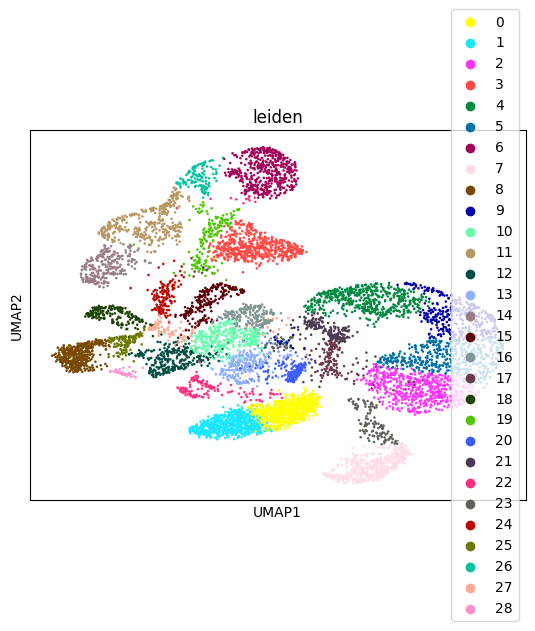

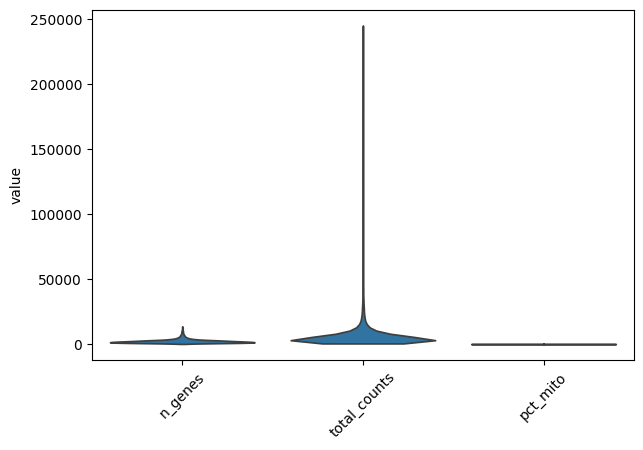

✓ X now contains denoised counts

[PHASE 2-3] ------ Step 3: QC Metrics & Cell Filtering ------
----------------------------------------------------------------------
✓ Computed QC metrics (found 13 mitochondrial genes)

Filtering cells...
Cells before: 8877
Cells after: 8728
  post_QC_filtering: 8728 cells
Filtering genes...
✓ Filtered genes: 13023 genes remain


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


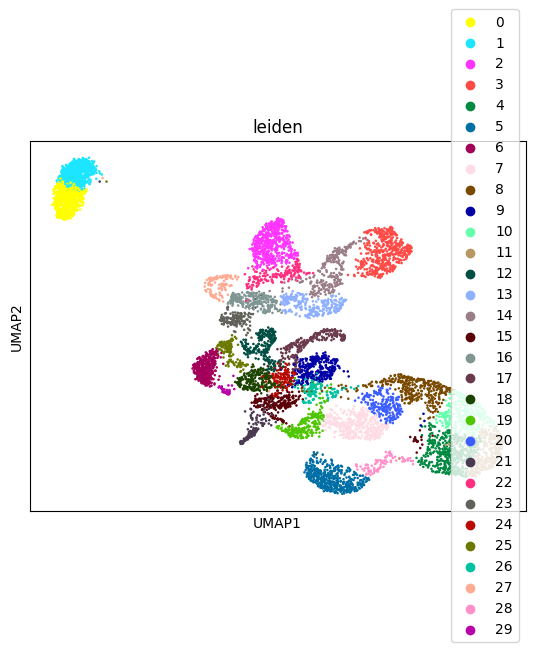

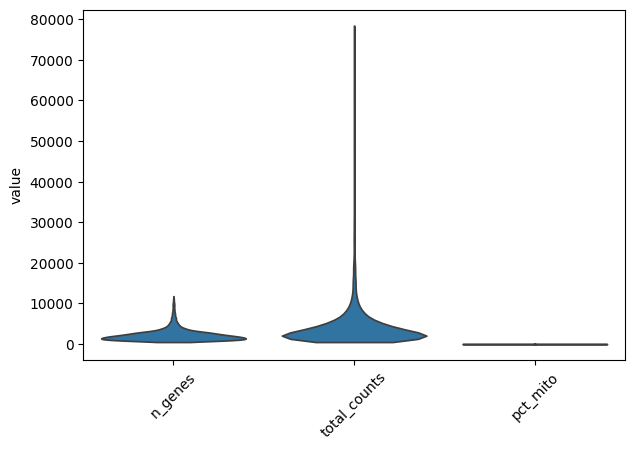


[PHASE 4] ====== Step 4-6: Doublet Detection with pK Sweep =======
----------------------------------------------------------------------
Running pK sweep for DoubletFinder...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


  pK=0.005: 0.0731 doublet fraction


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


  pK=0.01: 0.0724 doublet fraction


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


  pK=0.02: 0.0645 doublet fraction


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


  pK=0.03: 0.0627 doublet fraction


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


  pK=0.05: 0.0600 doublet fraction
✓ Selected pK=0.05 with doublet fraction 0.0600 (within tolerance)

Applying DoubletFinder with optimal pK=0.05...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")


✓ Removed 550 doublets
  post_doublet_auto: 8178 cells


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


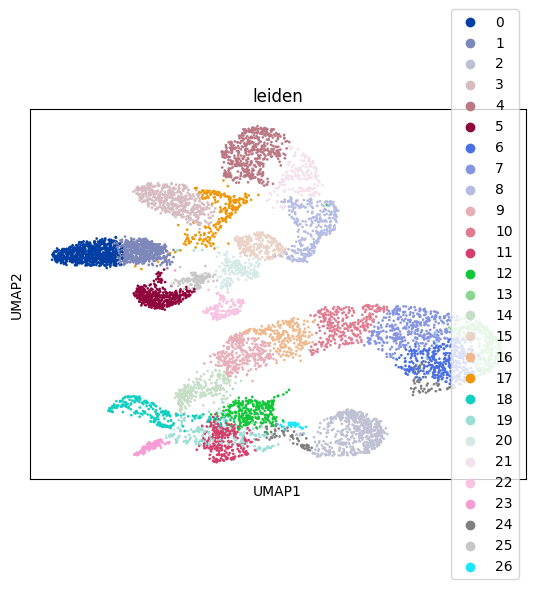

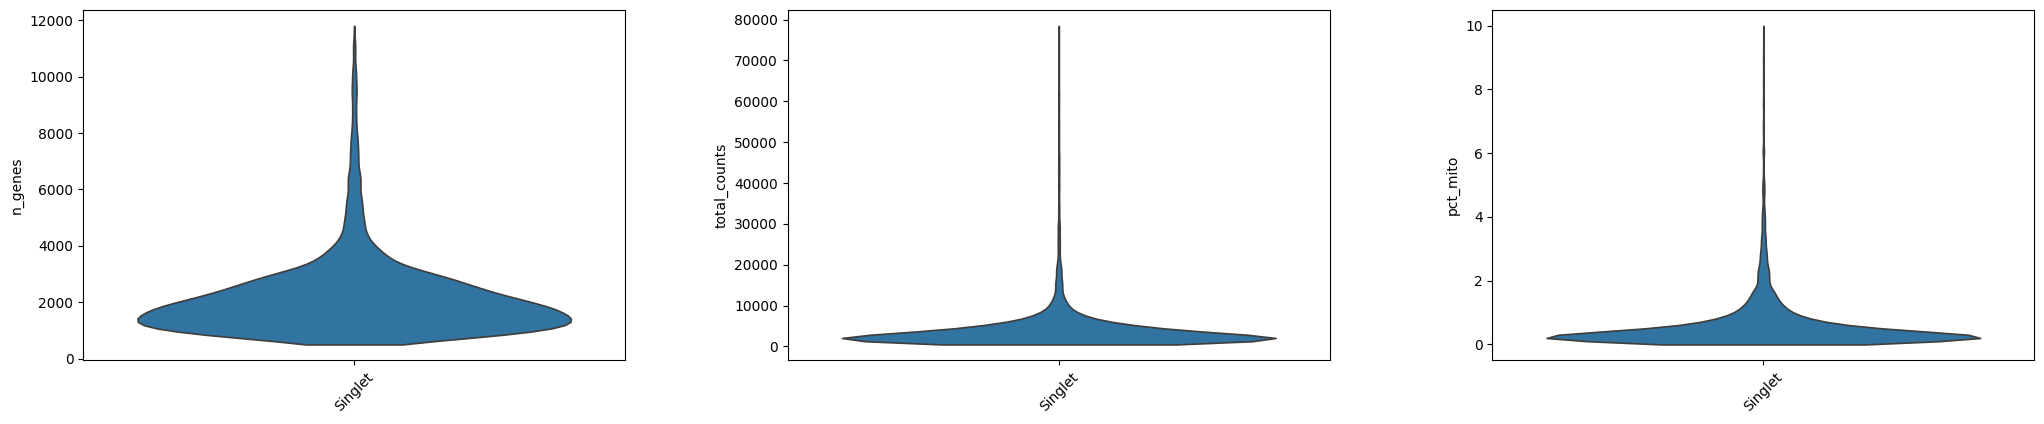


[PHASE 5-6] ====== Step 7-8: Manual Doublet Curation =======
----------------------------------------------------------------------
Preliminary clustering for doublet detection...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


Identified 18 potential doublet clusters: ['19', '21', '18', '8', '2', '20', '22', '23', '24', '4', '7', '10', '6', '11', '12', '13', '15', '26']
✓ Removed 4658 cells from manual doublet clusters
Re-clustering after manual doublet removal...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


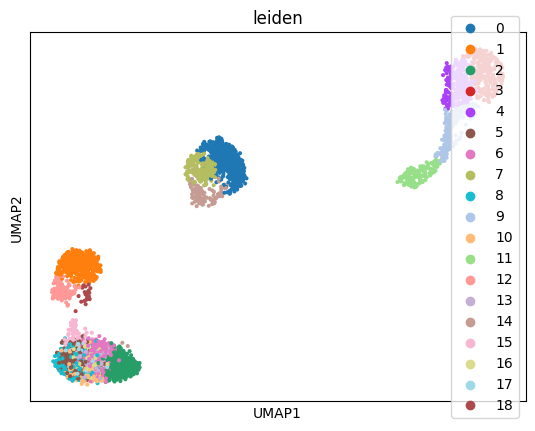

/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


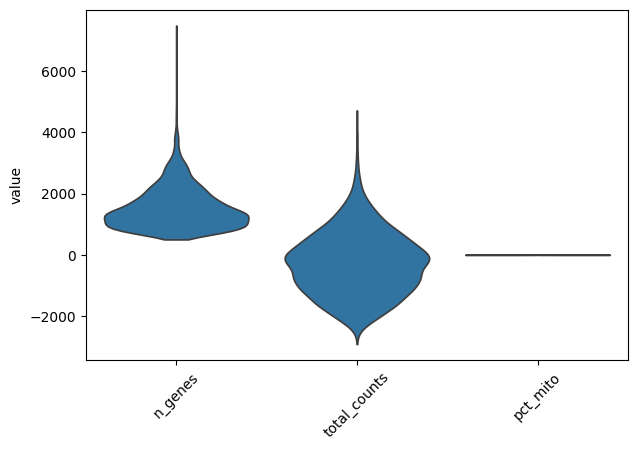

  post_doublet_manual: 3520 cells

[PHASE 7-9] ====== Step 9-13: Normalization, Clustering & Annotation =======
----------------------------------------------------------------------
Normalizing, scaling, and clustering...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/preprocessing/_pca/__init__.py:245: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  Version(ad.__version__) < Version("0.9")
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


✓ Clustering complete
Annotating cell types (3-level hierarchy)...
✓ Cell type annotation complete

[PHASE 10] ====== Step 14-19: Visualizations & Composition Plots =======
----------------------------------------------------------------------
------ Creating UMAP plots ------


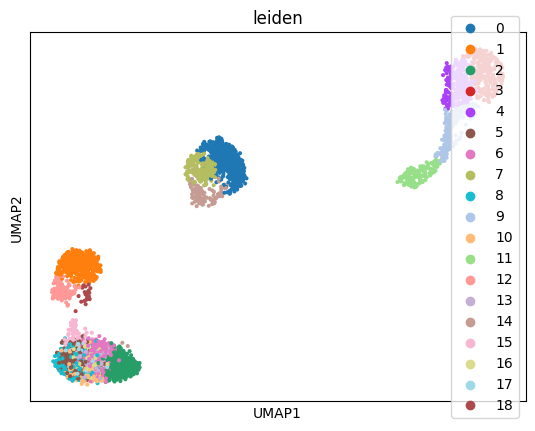

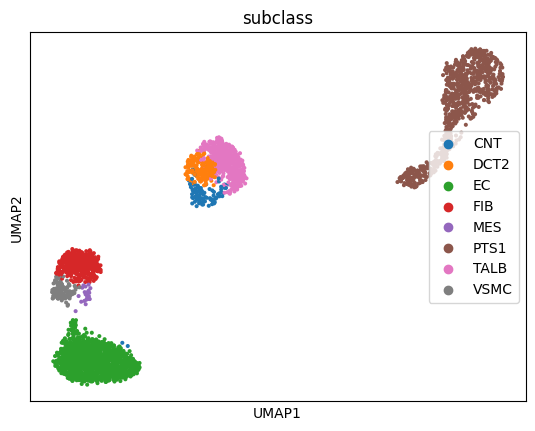

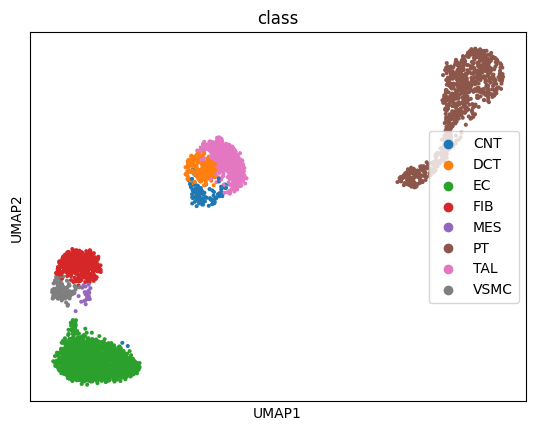

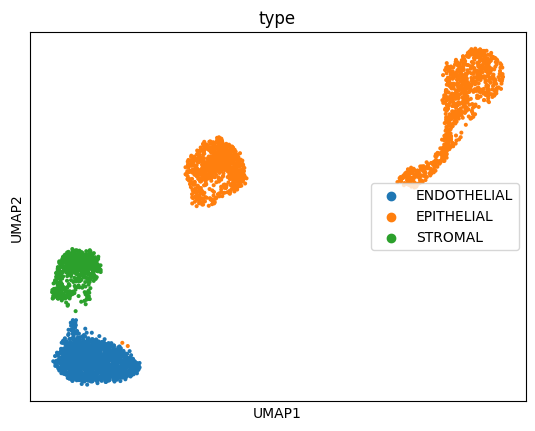

✓ UMAP plots saved
------ Creating composition plots ------
Saved: ./outputs/figures/Kidney_7_composition_subclass.pdf


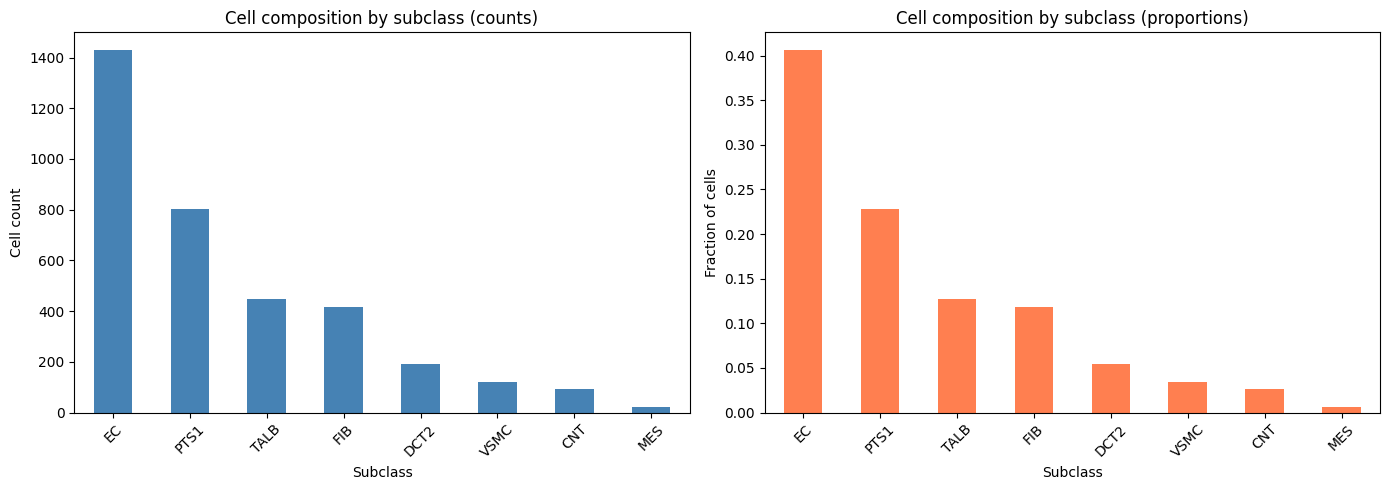

Saved: ./outputs/figures/Kidney_7_composition_class.pdf


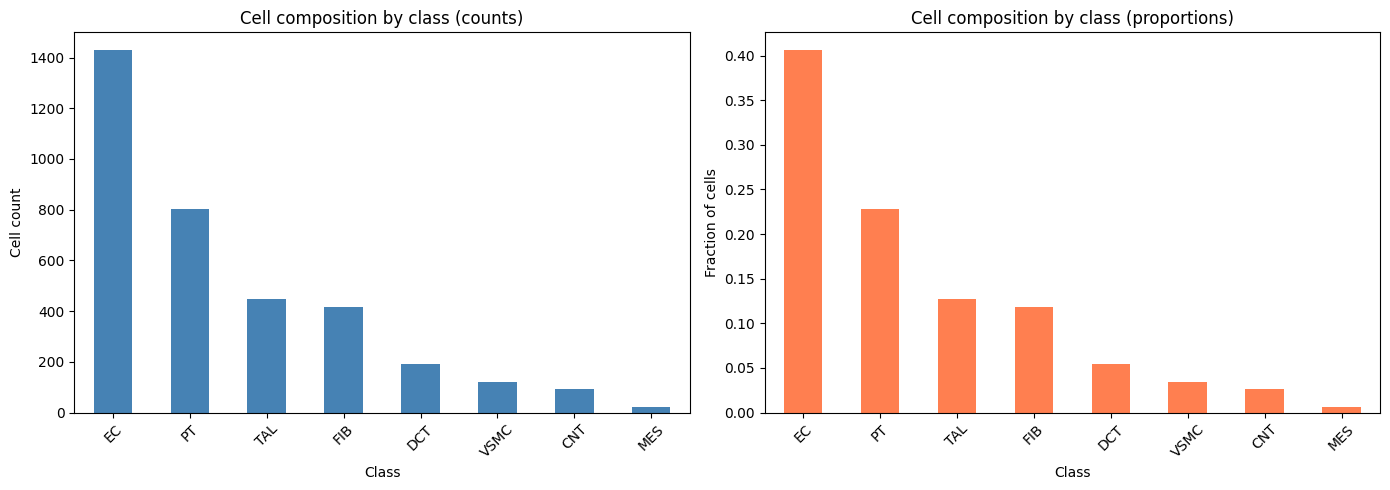

Saved: ./outputs/figures/Kidney_7_composition_type.pdf


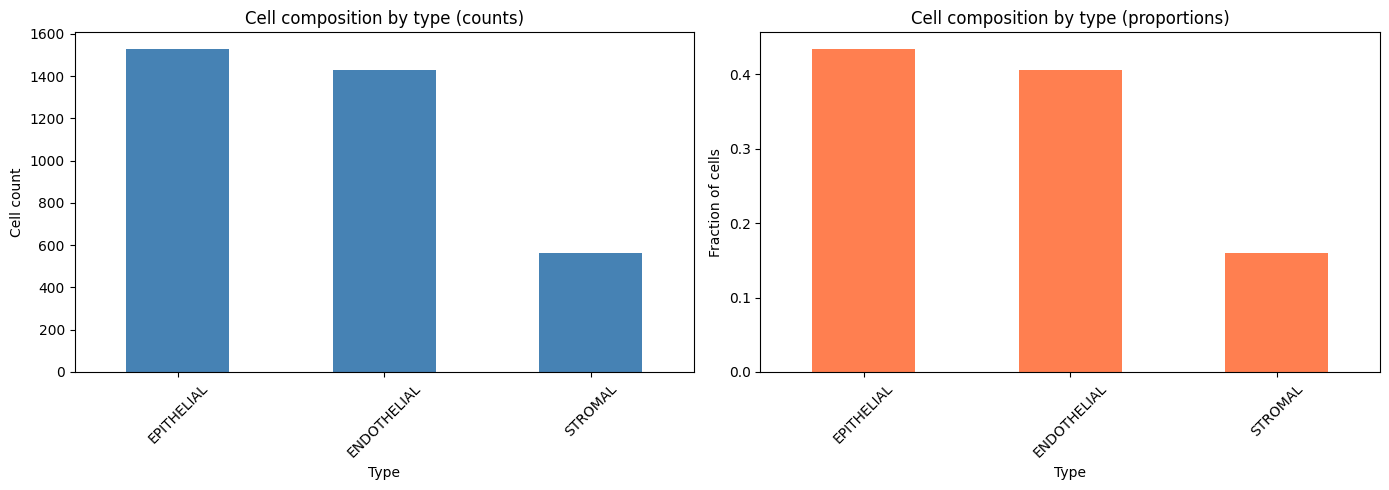

✓ Composition plots saved
------ Creating marker dotplot ------


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/plotting/_anndata.py:2074: FutureWarning: Use obs (e.g. `k in adata.obs` or `str(adata.obs.columns.tolist())`) instead of AnnData.obs_keys, AnnData.obs_keys is deprecated and will be removed in the future.
  if group not in [*adata.obs_keys(), adata.obs.index.name]:


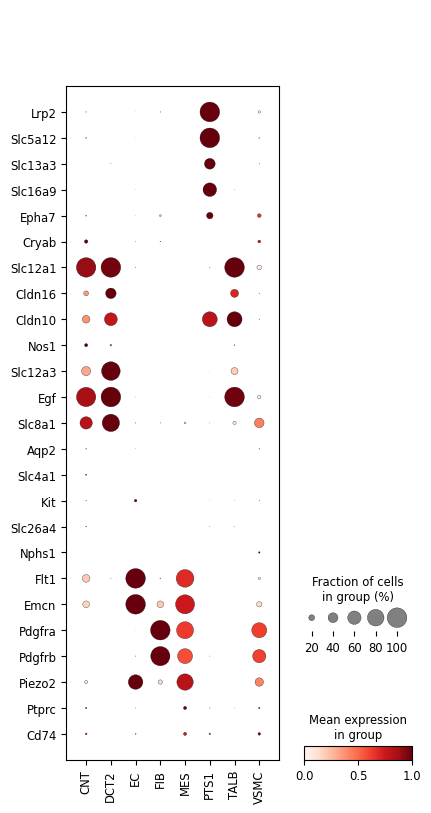

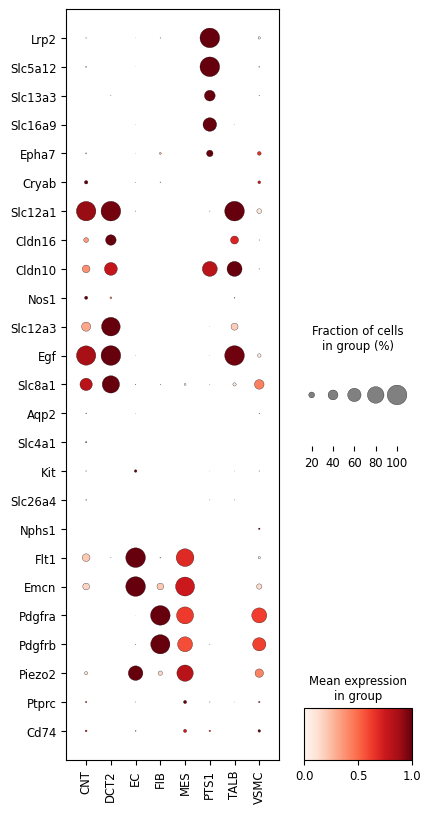

 Dotplot saved to: outputs/figures/Kidney_7_markers_dotplot.pdf (n markers present = 25)
✓ Dotplot saved

[PHASE 10] ====== Step 20-21: Differential Expression =======
----------------------------------------------------------------------
Finding markers...
Running DE on 8 groups with ≥20 cells...


/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/michaelhaidar/Documents/Vanderbilt/Brain_Research/scAgent/scQC/lib/python3.13/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/michaelhaidar/Documen

✓ Markers saved to ./outputs/20251019_FindAllMarkers_By_subclass.xlsx
✓ Marker Excel file: ./outputs/20251019_FindAllMarkers_By_subclass.xlsx

[PHASE 10] ====== Step 22-24: QC Report & Final Outputs =======
----------------------------------------------------------------------
  final: 3520 cells

✓ QC report saved to ./outputs/Kidney_7_qc_report.json

QC Report Summary:
  Sample: Kidney_7
  Date: 2025-10-19
  Final_Cells: 3520
  Genes_Detected: 13023
  Filtering_Steps: ['initial: 8877 cells', 'post_SCAR: 8877 cells', 'post_QC_filtering: 8728 cells', 'post_doublet_auto: 8178 cells', 'post_doublet_manual: 3520 cells', 'final: 3520 cells']
  Missing_Cell_Types: ['PTS2', 'PTS3', 'DTL', 'TALA', 'DCT1', 'PC', 'ICA', 'ICB', 'PODO']

SAVING RESULTS

Saving intermediate checkpoints...
Saving final annotated object...

✓ All outputs saved to: ./outputs
**ANALYSIS COMPLETE!**



In [25]:
def complete_kidney_analysis_pipeline(adata, sample_name, raw_adata, output_dir='./outputs'):
    """
    Complete kidney scRNAseq analysis pipeline following framework phases 2-10.
    Implements all required fixes and improvements.
    
    Parameters:
    -----------
    adata : AnnData object with raw filtered counts
    sample_name : name of sample
    raw_adata : raw (unfiltered) AnnData object
    output_dir : directory for outputs
    
    Returns:
    --------
    adata : final annotated AnnData object
    """
    import os
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(f'{output_dir}/figures', exist_ok=True)
    
    # Initialize QC tracker
    qc = QCTracker(sample_name)
    adata_initial = adata.copy()
    qc.add('initial', adata_initial)
    #first_report, adata = generate_qc_report(adata, sample_name)
    print("\n" + "="*70)
    print("======== KIDNEY scRNA-seq ANALYSIS PIPELINE =========")
    print("="*70)
    
    # ===== PHASE 2: Ambient RNA Correction =====
    print("\n[PHASE 2] ======= Step 1: Ambient RNA Correction (SCAR) ========")
    print("-" * 70)
    adata = denoise_with_scar(raw_adata, adata, max_epochs=25, prob=0.995)
    qc.add('post_SCAR', adata)
    
    # CRITICAL: Propagate denoised counts to X before any normalization
    print("\n[PHASE 2] ------ Step 2: Propagating denoised counts to working matrix X ------")
    if 'counts_raw' not in adata.layers:
        adata.layers['counts_raw'] = adata.layers.get('counts', adata.X).copy()
    if 'denoised' in adata.layers:
        adata.layers['counts_denoised'] = adata.layers.pop('denoised')
    else:
        raise ValueError("Expected 'denoised' layer after SCAR is missing.")

    checkpoint_umap(adata, "postSCAR", sample_name, output_dir=output_dir)

    violin_qc(adata, sample_name, 'postSCAR', groupby=None, output_dir=output_dir)

    # Set denoised counts as working matrix
    adata.X = adata.layers['counts_denoised'].copy()
    print(f"✓ X now contains denoised counts")
    
    # ===== PHASE 2-3: QC Metrics & Cell Filtering =====
    print("\n[PHASE 2-3] ------ Step 3: QC Metrics & Cell Filtering ------")
    print("-" * 70)
    
    # Compute mitochondrial metrics
    X_temp = adata.X.copy()
    mt_mask = adata.var_names.str.upper().str.startswith('MT-')
    adata.var['mt'] = mt_mask
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
    print(f"✓ Computed QC metrics (found {mt_mask.sum()} mitochondrial genes)")

    # 2) Provide the column names your filter expects
    if 'n_genes' not in adata.obs and 'n_genes_by_counts' in adata.obs:
        adata.obs['n_genes'] = adata.obs['n_genes_by_counts']

    if 'pct_mito' not in adata.obs and 'pct_counts_mt' in adata.obs:
        adata.obs['pct_mito'] = adata.obs['pct_counts_mt']

    # (optional) Some older utilities expect 'n_counts' instead of 'total_counts'
    if 'n_counts' not in adata.obs and 'total_counts' in adata.obs:
        adata.obs['n_counts'] = adata.obs['total_counts']
        
    # Cell filtering
    print("\nFiltering cells...")
    adata = filter_cells_by_qc(adata, min_genes=500, min_counts=500, pct_mito_thresh=10.0)
    qc.add('post_QC_filtering', adata)
    
    # Gene filtering (ENABLED as per framework)
    print("Filtering genes...")
    sc.pp.filter_genes(adata, min_cells=3)
    print(f"✓ Filtered genes: {adata.n_vars} genes remain")

    checkpoint_umap(adata, "postQC", sample_name, output_dir=output_dir)
    violin_qc(adata, sample_name, 'postQC', groupby=None, output_dir=output_dir)

    # ===== PHASE 4: Doublet Detection with pK Sweep =====
    print("\n[PHASE 4] ====== Step 4-6: Doublet Detection with pK Sweep =======")
    print("-" * 70)
    
    # Run pK sweep
    sweep = run_doublet_pk_sweep(adata, 
                                 pK_grid=(0.005, 0.01, 0.02, 0.03, 0.05),
                                 expected_rate=0.06,
                                 n_prin_comps=30,
                                 random_state=0)
    
    # Select optimal pK
    best_pK = choose_pk_from_sweep(sweep, expected_rate=0.06, tol=0.02)
    
    # Apply DoubletFinder with optimal pK
    print(f"\nApplying DoubletFinder with optimal pK={best_pK}...")
    adata = doubletfinder_style(adata, expected_doublet_rate=0.06, pK=best_pK, n_prin_comps=30)
    
    # Remove doublets
    n_doublets_before = adata.n_obs
    adata = adata[adata.obs['DF.class'] == 'Singlet'].copy()
    n_doublets_removed = n_doublets_before - adata.n_obs
    print(f"✓ Removed {n_doublets_removed} doublets")
    qc.add('post_doublet_auto', adata)

    checkpoint_umap(adata, "postDoubletAuto", sample_name, output_dir=output_dir)
    violin_qc(adata, sample_name, 'postDoubletFinder', groupby='DF.class', output_dir=output_dir)

    # ===== PHASE 5-6: Manual Doublet Curation & Re-clustering =====
    print("\n[PHASE 5-6] ====== Step 7-8: Manual Doublet Curation =======")
    print("-" * 70)
    
    # First, preliminary clustering for identifying doublet clusters
    print("Preliminary clustering for doublet detection...")
    # Cluster on adata (this will transform X temporarily)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, n_comps=40)
    sc.pp.neighbors(adata, n_pcs=40)
    sc.tl.leiden(adata, resolution=2.0)
    
    kidney_markers = {
        'Proximal_Tubule': ['Lrp2', 'Slc5a12', 'Slc13a3', 'Slc16a9'],
        'Endothelial': ['Flt1', 'Emcn', 'Pecam1'],
        'Fibroblast': ['Pdgfra', 'Col1a1'],
        'TAL': ['Slc12a1', 'Cldn16', 'Cldn10']
    }
    
    doublet_clusters, _ = identify_doublet_clusters(adata, kidney_markers)
    
    if doublet_clusters:
        
        print(f"Identified {len(doublet_clusters)} potential doublet clusters: {doublet_clusters}")
        adata.obs['manual_doublet'] = adata.obs['leiden'].isin(doublet_clusters)
        n_manual_before = adata.n_obs
        adata = adata[~adata.obs['manual_doublet']].copy()
        n_manual_removed = n_manual_before - adata.n_obs
        print(f"✓ Removed {n_manual_removed} cells from manual doublet clusters")
        
        # Re-cluster clean data
        print("Re-clustering after manual doublet removal...")
        sc.tl.leiden(adata, resolution=2.0)
        sc.tl.umap(adata)

    checkpoint_umap(adata, "postDoubletManual", sample_name, output_dir=output_dir)
    violin_qc(adata, sample_name, 'postDoubletManual', groupby=None, output_dir=output_dir)

    # reset X to denoised counts
    adata.X = adata.layers['counts_denoised']
    qc.add('post_doublet_manual', adata)
    
    # ===== PHASE 7-9: Normalization, Clustering, & Annotation =====
    print("\n[PHASE 7-9] ====== Step 9-13: Normalization, Clustering & Annotation =======")
    print("-" * 70)
    
    # Normalize and cluster (on denoised counts already in X)
    print("Normalizing, scaling, and clustering...")
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, n_comps=40)
    sc.pp.neighbors(adata, n_pcs=40)
    sc.tl.leiden(adata, resolution=2.0)
    sc.tl.umap(adata)
    print("✓ Clustering complete")
    
    # Annotate cell types
    print("Annotating cell types (3-level hierarchy)...")
    adata = annotate_kidney_cells(adata)
    print("✓ Cell type annotation complete")
    
    # ===== PHASE 10: Visualizations & Reports =====
    print("\n[PHASE 10] ====== Step 14-19: Visualizations & Composition Plots =======")
    print("-" * 70)
    
    # UMAP plots
    print("------ Creating UMAP plots ------")
    # Tell Scanpy where to put figures, once
    sc.settings.figdir = os.path.join(output_dir, "figures")
    os.makedirs(sc.settings.figdir, exist_ok=True)

    # (optional) make PDF the default figure format
    sc.settings.file_format_figs = "pdf"

    # UMAPs
    sc.pl.umap(adata, color=['leiden'],   legend_loc='right', save=f'_{sample_name}_leiden')
    sc.pl.umap(adata, color=['subclass'], legend_loc='right', save=f'_{sample_name}_subclass')
    sc.pl.umap(adata, color=['class'],    legend_loc='right', save=f'_{sample_name}_class')
    sc.pl.umap(adata, color=['type'],     legend_loc='right', save=f'_{sample_name}_type')

    print("✓ UMAP plots saved")
    
    # Composition plots
    print("------ Creating composition plots ------")
    plot_composition(adata, by='subclass', 
                     fname=f'{sample_name}_composition_subclass.pdf',
                     output_dir=f'{output_dir}/figures')
    plot_composition(adata, by='class', 
                     fname=f'{sample_name}_composition_class.pdf',
                     output_dir=f'{output_dir}/figures')
    plot_composition(adata, by='type', 
                     fname=f'{sample_name}_composition_type.pdf',
                     output_dir=f'{output_dir}/figures')
    print("✓ Composition plots saved")
    
    # Dotplot
    print("------ Creating marker dotplot ------")
    markers_present, dp_path = create_kidney_dotplot(
        adata, groupby="subclass", sample_name=sample_name, output_dir=output_dir, show=True
    )
    print(f" Dotplot saved to: {dp_path} (n markers present = {len(markers_present)})")

    print("✓ Dotplot saved")
    
    # ===== PHASE 10: Differential Expression =====
    print("\n[PHASE 10] ====== Step 20-21: Differential Expression =======")
    print("-" * 70)
    
    print("Finding markers...")
    marker_path = find_all_markers(adata, groupby='subclass', 
                                   output_path=f'{output_dir}/{dt.now().strftime("%Y%m%d")}_FindAllMarkers_By_subclass.xlsx',
                                   min_cells=20)
    print(f"✓ Marker Excel file: {marker_path}")
    
    # ===== PHASE 10: QC Report =====
    print("\n[PHASE 10] ====== Step 22-24: QC Report & Final Outputs =======")
    print("-" * 70)
    
    qc.add('final', adata)
    report = generate_qc_report(adata, sample_name, output_dir=output_dir, qc_tracker=qc)
    
    print("\nQC Report Summary:")
    for key, value in report.items():
        if key not in ['Stage_Wise_Counts', 'Cell_Type_Composition']:
            print(f"  {key}: {value}")
    
    # ===== Save Results =====
    print("\n" + "="*70)
    print("SAVING RESULTS")
    print("="*70)
    
    # Timestamped outputs
    date_stamp = dt.now().strftime("%Y%m%d")
    
    # Save intermediate checkpoints
    print(f"\nSaving intermediate checkpoints...")
    adata_initial.write_h5ad(f'{output_dir}/{date_stamp}_{sample_name}_step00_initial.h5ad')
    
    # Save final object
    print(f"Saving final annotated object...")
    adata.write_h5ad(f'{output_dir}/{date_stamp}_{sample_name}_final.h5ad')
    
    print(f"\n✓ All outputs saved to: {output_dir}")
    print("="*70)
    print("**ANALYSIS COMPLETE!**")
    print("="*70 + "\n")
    
    return adata


# Run the complete pipeline
print("Starting kidney pipeline analysis...")
adata_final = complete_kidney_analysis_pipeline(filtered, "Kidney_7", raw, output_dir='./outputs')